<a href="https://colab.research.google.com/github/armanibrayeva/MPI/blob/main/Stanford_SST_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# Complete Sit-to-Stand Feature Extraction - Compatible with NumPy 2.0
# ============================================================================

# CELL 1: Mount Drive and Install Dependencies
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

# Install required packages
!pip install -q opencv-python-headless scipy pandas

print("✓ Setup complete")

# ============================================================================
# CELL 2: Create edits.py
# ============================================================================

edits_content = """
tofix = {
    "k4Zz5q1I": [75, 240],
    "hozGKSGr": [60, 250],
    "8iHK3CGi": [550, 1000],
    "9qluCnOn": [0, 400],
    "zyW3PPtt": [-1,-1],
    "hMvHwAPy": [115, 270],
    "Ytlu6T69": [50, 250],
    "0jYyyP9R": [50, 750],
    "y3ET3wKE": [40, 300],
    "P5wlKd0H": [50, 350],
    "HpYl7dTS": [50, 300],
    "2SV6hYB2": [50, 250],
    "o9xCf7YI": [50, 250],
    "ut7ckdyI": [50, 450],
    "ULS1fTmQ": [50, 500],
    "gXhE9VUw": [50, 350],
}
tocheck = {}
toremove = {}
"""

with open("edits.py", "w") as f:
    f.write(edits_content)

print("✓ edits.py created")

# ============================================================================
# CELL 3: Create utils.py with NumPy 2.0 compatibility fixes
# ============================================================================

utils_content = """
import os
import json
import numpy as np
import subprocess
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import interp1d, splrep, splev
import pandas as pd
from scipy import interpolate
import csv
import cv2
import pickle
import sys
from edits import tofix, tocheck, toremove

FPS = 30.0

NOSE = 0
NECK = 1
RSHO = 2
RELB = 3
RWRI = 4
LSHO = 5
LELB = 6
LWRI = 7
MHIP = 8
RHIP = 9
RKNE = 10
RANK = 11
LHIP = 12
LKNE = 13
LANK = 14
REYE = 15
LEYE = 16
REAR = 17
LEAR = 18
LBTO = 19
LSTO = 20
LHEL = 21
RBTO = 22
RSTO = 23
RHEL = 24
VERT = 25
LAH = 26
RAH = 27

def get_framerate(filepath, videoid):
    try:
        res = subprocess.check_output("ffprobe -v error -select_streams v -of default=noprint_wrappers=1:nokey=1 -show_entries stream=r_frame_rate {}".format(filepath).split(" "))
        res = tuple(map(float, res.decode().rstrip().split("/")))
        res = res[0]/res[1]
    except:
        print("{}".format(videoid))
        res = None
    return res

videometa = {}

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
    if x is None:
        x = np.arange(len(v))
    v = np.asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = np.inf, -np.inf  # FIXED: was np.Inf
    mnpos, mxpos = np.nan, np.nan
    lookformax = True
    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
    return np.array(maxtab), np.array(mintab)

def get_angle(A,B,C,data):
    p_A = np.array([data[:,3*A],data[:,3*A+1]]).T
    p_B = np.array([data[:,3*B],data[:,3*B+1]]).T
    p_C = np.array([data[:,3*C],data[:,3*C+1]]).T
    p_BA = p_A - p_B
    p_BC = p_C - p_B
    dot_products = np.sum(p_BA*p_BC,axis=1)
    norm_products = np.linalg.norm(p_BA,axis=1)*np.linalg.norm(p_BC,axis=1)
    norm_products[norm_products == 0] = 1e-9
    argument = np.clip(dot_products/norm_products, -1.0, 1.0)
    return np.arccos(argument)

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def smooth_ts(ts, framerate = 30, s = 0.01):
    return butter_lowpass_filter(ts, 6, framerate)

SAVE_FIGS = False
MORE_PLOTS = False

def fill_nan(A):
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    if(len(good[0]) <= 1):
        return A
    f = interpolate.interp1d(inds[good], A[good],kind="linear",bounds_error=False,fill_value="extrapolate")
    B = np.where(np.isfinite(A),A,f(inds))
    B = np.where(np.isfinite(B),B,np.nanmean(B))
    return B

def mean_perc(ts):
    ts = ts[~np.isnan(ts)]
    if len(ts) == 0: return 0.0
    low = np.percentile(ts, 5)
    high = np.percentile(ts, 95)
    ts = ts[ts > low]
    ts = ts[ts < high]
    return np.mean(ts) if len(ts) > 0 else 0.0

def center_ts(res):
    scale_vec = (res[:,(NECK*3):(NECK*3+3)] - res[:,(MHIP*3):(MHIP*3+3)])[:,:2]
    scale = np.sqrt(np.sum(scale_vec**2,axis=1))
    scale = mean_perc(scale)
    if scale == 0: scale = 1.0

    X = mean_perc(res[:,RANK*3])
    Y = mean_perc(res[:,RANK*3+1])

    for i in range(25):
        res[:,(i*3):(i*3+3)] = res[:,(i*3):(i*3+3)] - np.hstack([X,Y,0])[None,:]
    return res /scale

def get_angle_stats(A, B, C, res, breaks, framerate = 30, name = None, alternate = 0, breaks_alt=None):
    is3d = len(res.shape) == 3
    if is3d:
        name += "_3d"
        langle = get_angle3d(A, B, C, res)
    else:
        langle = get_angle(A, B, C, res)

    langle = np.nan_to_num(langle)
    minv, maxv, vel, acc, vel_max, vel_min, acc_max, acc_min, diffs, sds = [],[],[],[],[],[],[],[],[],[]

    for i in range(len(breaks)-1):
        if (alternate==1) and i % 2 == 1: continue
        if (alternate==-1) and i % 2 == 0: continue
        lang = langle[breaks[i]:breaks[i+1]]
        y = (lang)*180/np.pi
        if len(y) < 2: continue

        n = y.shape[0]
        minv.append(np.quantile(y, 0.05))
        maxv.append(np.quantile(y, 0.95))
        v = (y[1:n] - y[0:(n-1)])*framerate
        if len(v) < 2: continue
        a = (v[1:] - v[:-1])*framerate

        diffs.append( np.quantile(y, 0.95) - np.quantile(y, 0.05) )
        sds.append( np.std(y) )
        vel.append( np.median(v) )
        acc.append( np.median(a) if len(a) > 0 else 0 )
        vel_max.append( np.quantile(v, 0.95) )
        acc_max.append( np.quantile(a, 0.95) if len(a) > 0 else 0)
        vel_min.append( np.quantile(v, 0.05) )
        acc_min.append( np.quantile(a, 0.05) if len(a) > 0 else 0)

    sts = ""
    if alternate == 1: sts = "_sit2stand"
    if alternate == -1: sts = "_stand2sit"

    return {
        f"{name}_range_mean{sts}": np.mean(diffs) if diffs else 0,
        f"{name}_sd{sts}": np.mean(sds) if sds else 0,
        f"{name}_max{sts}": max(maxv) if maxv else 0,
        f"{name}_min{sts}": min(minv) if minv else 0,
        f"{name}_max_mean{sts}": np.array(maxv).mean() if maxv else 0,
        f"{name}_min_mean{sts}": np.array(minv).mean() if minv else 0,
        f"{name}_max_sd{sts}": np.array(maxv).std() if maxv else 0,
        f"{name}_min_sd{sts}": np.array(minv).std() if minv else 0,
        f"{name}_ang_vel{sts}": np.array(vel).mean() if vel else 0,
        f"{name}_ang_acc{sts}": np.array(acc).mean() if acc else 0,
        f"{name}_max_ang_vel{sts}": np.array(vel_max).mean() if vel_max else 0,
        f"{name}_max_ang_acc{sts}": np.array(acc_max).mean() if acc_max else 0,
        f"{name}_min_ang_vel{sts}": np.array(vel_min).mean() if vel_min else 0,
        f"{name}_min_ang_acc{sts}": np.array(acc_min).mean() if acc_min else 0,
    }

def get_angles_results(res, breaks, framerate = 30, alternate = 0, breaks_alt = None):
    is3d = len(res.shape)==3
    res = res.copy()
    if is3d:
        vert = res[:,MHIP,:].copy()
        vert[:,1] = vert[:,1] + 10
        lah = res[:,LKNE,:].copy()
        lah[:,1] = res[:,LANK,1]
        rah = res[:,RKNE,:].copy()
        rah[:,1] = res[:,RANK,1]
        extras = np.stack([vert, lah, rah],axis=1)
        res = np.hstack([res.copy(), extras])
    else:
        orientation = res[breaks[0], LKNE*3] > res[breaks[0], RKNE*3]
        vert = res[:,(MHIP*3):(MHIP*3+3)].copy()
        vert[:,1] = vert[:,1] - 10
        lah = res[:,(LANK*3):(LANK*3+3)].copy()
        lah[:,0] = lah[:,0] + orientation*10
        rah = res[:,(RANK*3):(RANK*3+3)].copy()
        rah[:,0] = rah[:,0] + orientation*10
        res = np.hstack([res.copy(), vert, lah, rah])
    results = {}
    results.update(get_angle_stats(LANK, LKNE, LHIP, res, breaks, name="left_knee", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(RANK, RKNE, RHIP, res, breaks, name="right_knee", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(NECK, LHIP, LKNE, res, breaks, name="left_hip", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(NECK, RHIP, RKNE, res, breaks, name="right_hip", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(LBTO, LANK, LKNE, res, breaks, name="left_ankle", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(RBTO, RANK, RKNE, res, breaks, name="right_ankle", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(VERT, MHIP, NECK, res, breaks, name="trunk_lean", framerate = framerate, alternate = alternate, breaks_alt = breaks_alt))
    results.update(get_angle_stats(LKNE, LANK, LAH, res, breaks, name="left_shank_angle", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(RKNE, RANK, RAH, res, breaks, name="right_shank_angle", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(NECK, RKNE, RANK, res, breaks, name="alignment", framerate = framerate, alternate = alternate))
    results.update(get_angle_stats(NECK, MHIP, 25, res, breaks, name="trunk"))
    return results

def get_time_results(res, breaks, framerate = 30, alternate=0):
    times, speeds, diffs, last_time = [], [], [], 0
    for i in range(len(breaks)-1):
        time = float((breaks[i+1] - breaks[i])/framerate)
        speed = 1/time if time > 0 else 0
        if (alternate == 1) and i % 2 == 1:
            last_time = time
            continue
        if (alternate == -1) and i % 2 == 0:
            last_time = time
            continue
        times.append(time)
        speeds.append(speed)
        if i > 0: diffs.append(time-last_time)
        last_time = time
    total_time = sum(times)
    sts = ""
    if alternate == 1: sts = "_sit2stand"
    if alternate == -1: sts = "_stand2sit"
    return {
        f"n{sts}": len(times),
        f"time{sts}": total_time,
        f"time_diff{sts}": np.array(diffs).mean() if diffs else 0,
        f"speed{sts}": round(len(times)/total_time,2) if total_time > 0 else 0,
        f"time_sd{sts}": np.array(times).std() if times else 0,
        f"speed_sd{sts}": np.array(speeds).std() if speeds else 0,
    }

def get_joint_speed(joint, res):
    n = res.shape[0]
    return res[1:n,(joint*3):(joint*3+3)] - res[0:(n-1),(joint*3):(joint*3+3)]

def get_joint_speed3d(joint, res):
    n = res.shape[0]
    return res[1:n,joint,:] - res[0:(n-1),joint,:]

def get_static(res, down, up):
    if len(down) == 0 or len(up) == 0: return {}
    is3d = len(res.shape) == 3
    is3d_str = "_3d" if is3d else ""
    if is3d:
        ank_dist_mag = np.linalg.norm(res[:,RANK,:] - res[:,LANK,:], axis=1)
        knee_dist_mag = np.linalg.norm(res[:,RKNE,:] - res[:,LKNE,:], axis=1)
        hip_dist_mag = np.linalg.norm(res[:,RHIP,:] - res[:,LHIP,:], axis=1)
        height_mag = np.linalg.norm((res[:,RANK,:] + res[:,LANK,:])/2 - res[:,NOSE,:], axis=1)
        lkeee_angle = get_angle3d(LANK, LKNE, LHIP, res)*180/np.pi
        rkeee_angle = get_angle3d(RANK, RKNE, RHIP, res)*180/np.pi
    else:
        ank_dist_mag = np.linalg.norm(res[:,RANK*3:(RANK*3+2)] - res[:,LANK*3:(LANK*3+2)], axis=1)
        knee_dist_mag = np.linalg.norm(res[:,RKNE*3:(RKNE*3+2)] - res[:,LKNE*3:(LKNE*3+2)], axis=1)
        hip_dist_mag = np.linalg.norm(res[:,RHIP*3:(RHIP*3+2)] - res[:,LHIP*3:(LHIP*3+2)], axis=1)
        height_mag = np.linalg.norm((res[:,RANK*3:(RANK*3+2)] + res[:,LANK*3:(LANK*3+2)])/2 - res[:,NOSE*3:(NOSE*3+2)], axis=1)
        lkeee_angle = get_angle(LANK, LKNE, LHIP, res)*180/np.pi
        rkeee_angle = get_angle(RANK, RKNE, RHIP, res)*180/np.pi
    hip_dist_mag[hip_dist_mag == 0] = 1
    return {
        "ank_to_hip_dist_sit"+is3d_str: (ank_dist_mag / hip_dist_mag)[down].mean(),
        "ank_to_hip_dist_stand"+is3d_str: (ank_dist_mag / hip_dist_mag)[up].mean(),
        "knee_to_hip_dist_sit"+is3d_str: (knee_dist_mag / hip_dist_mag)[down].mean(),
        "knee_to_hip_dist_stand"+is3d_str: (knee_dist_mag / hip_dist_mag)[up].mean(),
        "height"+is3d_str: height_mag[up].mean(),
        "lknee_angle_first_sit"+is3d_str: lkeee_angle[down[0]],
        "rknee_angle_first_sit"+is3d_str: rkeee_angle[down[0]],
        "lknee_angle_first_stand"+is3d_str: lkeee_angle[up[0]],
        "rknee_angle_first_stand"+is3d_str: rkeee_angle[up[0]],
    }

def get_speed_stats(joint, res, breaks, framerate=30, name="pelvic", alternate=False):
    is3d = len(res.shape) == 3
    if is3d:
        trunk_speed = get_joint_speed3d(joint, res)[:,0:3] * framerate
        name += "_3d"
    else:
        trunk_speed = get_joint_speed(joint, res)[:,0:2] * framerate
    trunk_speed_mag = np.linalg.norm(trunk_speed, axis=1)

    if len(trunk_speed) < 2: return {}
    n = trunk_speed.shape[0]
    trunk_acc = (trunk_speed[1:n,:] - trunk_speed[0:(n-1),:]) * framerate
    trunk_acc_mag = np.linalg.norm(trunk_acc, axis=1)

    slices = []
    if alternate !=0:
        for i in range(len(breaks)-1):
            if alternate == 1 and i % 2 == 1: continue
            if alternate == -1 and i % 2 == 0: continue
            slices += list(range(breaks[i], breaks[i+1]))
    else:
        slices = list(range(breaks[0], breaks[-1]))

    slices = [s for s in slices if s < len(trunk_speed_mag)]
    if not slices: return {}
    trunk_speed_mag = trunk_speed_mag[slices]
    trunk_speed_mag = trunk_speed_mag[trunk_speed_mag < np.percentile(trunk_speed_mag, 95)]

    slices_acc = [s for s in slices if s < len(trunk_acc_mag)]
    if not slices_acc: return {}
    trunk_acc_mag = trunk_acc_mag[slices_acc]
    trunk_acc_mag = trunk_acc_mag[trunk_acc_mag < np.percentile(trunk_acc_mag, 95)]

    sts = ""
    if alternate == 1: sts = "_sit2stand"
    if alternate == -1: sts = "_stand2sit"
    return {
        f"{name}_avg_speed{sts}": np.median(trunk_speed_mag) if len(trunk_speed_mag) > 0 else 0,
        f"{name}_max_speed{sts}": np.quantile(trunk_speed_mag, 0.95) if len(trunk_speed_mag) > 0 else 0,
        f"{name}_avg_acc{sts}": np.median(trunk_acc_mag) if len(trunk_acc_mag) > 0 else 0,
        f"{name}_max_acc{sts}": np.quantile(trunk_acc_mag, 0.95) if len(trunk_acc_mag) > 0 else 0,
    }

def get_acceleration_results(res, breaks, framerate=30, alternate=0):
    results = {}
    results.update(get_speed_stats(MHIP, res, breaks, name="pelvic", framerate = framerate, alternate=alternate))
    results.update(get_speed_stats(NECK, res, breaks, name="neck", framerate = framerate, alternate=alternate))
    return results

def get_angle3d(A,B,C,data):
    p_A = data[:,A,:]
    p_B = data[:,B,:]
    p_C = data[:,C,:]
    p_BA = p_A - p_B
    p_BC = p_C - p_B
    dot_products = np.sum(p_BA*p_BC,axis=1)
    norm_products = np.linalg.norm(p_BA,axis=1)*np.linalg.norm(p_BC,axis=1)
    norm_products[norm_products == 0] = 1e-9
    argument = np.clip(dot_products/norm_products, -1.0, 1.0)
    return np.arccos(argument)

def get_segments(res, magnitude = 1, magnitude_loc = 1, framerate = 30):
    nose_y = res[:,[NOSE*3+1,]]
    neck_y = res[:,[NECK*3+1,]]
    ind_y = (neck_y + nose_y)/2
    x=range(len(ind_y))
    f = splrep(x, ind_y, s=magnitude)
    ind_y_smooth = splev(x, f)
    vmax, vmin = np.quantile(ind_y,0.99), np.quantile(ind_y,0.01)

    # FIXED: Check for valid delta before calling peakdet
    delta = np.sqrt(magnitude)*(vmax - vmin)/2
    if delta <= 0 or not np.isfinite(delta):
        return np.array([]), np.array([])

    ups,downs = peakdet(ind_y_smooth, delta)
    if ups.shape[0] == 0 or downs.shape[0] == 0:
        return np.array([]), np.array([])
    ups = ups[:,0].astype(np.uint16)
    downs = downs[:,0].astype(np.uint16)
    ups.sort()
    downs.sort()
    return ups, downs

def swap_columns(res, A, B):
    tmp = res[:,(A*3):(A*3+3)].copy()
    res[:,(A*3):(A*3+3)] = res[:,(B*3):(B*3+3)]
    res[:,(B*3):(B*3+3)] = tmp

toswap = [[RSHO, LSHO], [RELB, LELB], [RWRI, LWRI], [RHIP, LHIP], [RKNE, LKNE], [RANK, LANK], [REYE, LEYE], [REAR, LEAR], [RHEL, LHEL], [RSTO, LSTO], [RBTO, LBTO]]

realign = { "5gtBtMlE": {1: 110}, "e13bsM5a": {3: 205}, "P5wlKd0H": {1: 82, 4: 283}, "VPQJGG4D": {2: 160}, "zSWVNAon": {1: 79}, "eOBg4mwH": {0: 120}, "5illwZ0w": {1: 118}, "YuPB2PLf": {1: 710}, "QFWxKvJ3": {1: 139}, "Zj2jtm25": {1: 105}, "fayp3GUT": {1: 143}, "ztKJoXiw": {1: 320}, "0nUjlcd7": {2: 200}, "GESYi2xq": {0: 20}, "ULS1fTmQ": {1: 120, 3: 320, 4: 420}, "i9oVbbz6": {4: 550}, "y3ET3wKE": {2: 160, 3: 235}, "FsNM5n5s": {1: 50}, "UDXlpEgF": {1: 85}, "Ytlu6T69": {0: 115}, "8dLqK0KT": {1: 65}, "bFIh8shd": {2: 150}, "GwvQ3hpI": {1: 120}, "Je470A3u": {2: 160}, "uQaqBtOs": {1: 115}, "MfzjZe52": {1: 123, 2: 236}, "RhRnfeBp": {2: 210}, "a59COYtO": {1: 128, 2: 200, 3: 260}, "GITsdVy7": {4: 280}, "A5ya7RsN": {1: 105}, "T3aA8TCd": {1: 100, 2: 160, 3: 225}, "gXhE9VUw": {1: 75, 4: 260}, "0jYyyP9R": {1: 200, 4: 650}, "K7pXSGJ9": {1: 130, 2: 240}, "o9xCf7YI": {2: 165}, "ut7ckdyI": {1: 120, 2: 200, 4: 360}, "k3YTjMU4": {1: 80, 4: 300}, "HpYl7dTS": {1: 100, 3: 240}, "W0BHMtXT": {1: 110, 3: 240}, "oSFbRH4g": {3: 225}, "2SV6hYB2": {1: 110, 2: 180}}

def process_subject(subjectid, processed_npy_path="videos/np/", framerate = 30.0):
    res = np.load(f"{processed_npy_path}{subjectid}.npy")
    if subjectid == "pmYdj2Zc": res = res[:-10,:]
    res[:,1::3] = 50 + np.nanmax(res[:,1::3]) - res[:,1::3]

    md = np.median((res[:,MHIP*3] - (res[:,LKNE*3] + res[:,RKNE*3])/2 ))
    orientation = "R" if md < 0 else "L"
    if orientation == "L":
        res[:,0::3] = 1 + np.nanmax(res[:,0::3])-res[:,0::3]
        for cols in toswap: swap_columns(res, cols[0], cols[1])

    first, last, magnitude = 0, res.shape[0]-0, 1
    if subjectid in tofix:
        first, last = tofix[subjectid][0], tofix[subjectid][1]

    res = res[first:last,:]
    res[res < 0.5] = np.nan
    if subjectid == "zyW3PPtt":
        res[res[:,NOSE*3+1] < -1,NOSE*3+1] = np.nan

    res = np.apply_along_axis(fill_nan,arr=res,axis=0)
    res = center_ts(res)
    ups, downs = get_segments(res, magnitude=magnitude, framerate = framerate)
    if len(ups) == 0 or len(downs) == 0:
        print(f"Could not find peaks for {subjectid}. Skipping.")
        return None

    if subjectid in realign:
        for k,v in realign[subjectid].items():
            if k < len(downs): downs[k] = v

    allbreaks = sorted(ups.tolist() + downs.tolist())
    if len(allbreaks) < 2: return None
    if allbreaks[1] == downs[0]: allbreaks = allbreaks[1:]
    if len(allbreaks) == 0 or allbreaks[0] != downs[0]: return None
    if len(allbreaks)%2 == 1: allbreaks=allbreaks[:-1]
    allbreaks = np.array(allbreaks)

    results = {"subjectid": subjectid, "orientation": orientation, "framerate": framerate}
    lengths = res[ups[1]:ups[-2],3*NOSE:(3*NOSE+2)] - res[ups[1]:ups[-2],3*RANK:(3*RANK+2)] if len(ups) > 2 else res[:,3*NOSE:(3*NOSE+2)] - res[:,3*RANK:(3*RANK+2)]
    lengths = np.sqrt(np.sum(lengths**2, axis=1))
    height = np.quantile(lengths, 0.95) if len(lengths) > 0 else 1.0
    if height == 0: height = 1.0

    for i in range(3*25): res[:,i] = smooth_ts(res[:,i], framerate)
    delta = res[:,3*RANK:(3*RANK+2)].copy()
    for i in range(res.shape[1]//3):
        res[:,3*i:(3*i+2)] = (res[:,3*i:(3*i+2)] - delta)/height

    results.update(get_time_results(res, downs, framerate = framerate))
    results.update(get_time_results(res, allbreaks, framerate = framerate, alternate=1))
    results.update(get_time_results(res, allbreaks, framerate = framerate, alternate=-1))
    results.update(get_angles_results(res, downs, framerate = framerate, breaks_alt = ups))
    results.update(get_angles_results(res, allbreaks, framerate = framerate, alternate=1))
    results.update(get_angles_results(res, allbreaks, framerate = framerate, alternate=-1))
    results.update(get_acceleration_results(res, downs, framerate = framerate))
    results.update(get_acceleration_results(res, allbreaks, framerate = framerate, alternate=1))
    results.update(get_acceleration_results(res, allbreaks, framerate = framerate, alternate=-1))
    results.update(get_static(res, downs, ups))
    return results
"""

with open("utils.py", "w") as f:
    f.write(utils_content)

print("✓ utils.py created with NumPy 2.0 compatibility")

# ============================================================================
# CELL 4: Extract and prepare NPY files
# ============================================================================

zip_file_path = '/content/drive/My Drive/np.zip'
output_folder_path = '/content/npy_files/'

print(f"Looking for ZIP file at: {zip_file_path}")

if not os.path.exists(zip_file_path):
    print("ERROR: 'np.zip' not found in your Google Drive root folder.")
    print("Please upload it and make sure it's named exactly 'np.zip'")
else:
    print("ZIP file found. Extracting...")
    !mkdir -p "{output_folder_path}"
    !unzip -q "{zip_file_path}" -d "{output_folder_path}"
    print("✓ Files extracted successfully")

# ============================================================================
# CELL 5: Process all NPY files and extract features
# ============================================================================

import pandas as pd
from tqdm.notebook import tqdm
import importlib
import utils

# Reload utils to get the updated version
importlib.reload(utils)

NPY_FILES_PATH = '/content/npy_files/np/'

if not os.path.isdir(NPY_FILES_PATH):
    print(f"ERROR: Directory not found: {NPY_FILES_PATH}")
    print("Please check the extraction step above.")
else:
    all_files = [f for f in os.listdir(NPY_FILES_PATH) if f.endswith('.npy')]

    if not all_files:
        print(f"ERROR: No .npy files found in {NPY_FILES_PATH}")
    else:
        print(f"Found {len(all_files)} .npy files to process.\n")

        all_features = []
        failed_files = []

        for filename in tqdm(all_files, desc="Processing files"):
            try:
                subject_id = filename.replace('.npy', '')
                features = utils.process_subject(
                    subjectid=subject_id,
                    processed_npy_path=NPY_FILES_PATH,
                    framerate=30.0
                )

                if features:
                    all_features.append(features)
                else:
                    failed_files.append(filename)

            except Exception as e:
                print(f"\nError processing {filename}: {str(e)}")
                failed_files.append(filename)

        # Save results
        if all_features:
            df = pd.DataFrame(all_features)
            output_csv_path = '/content/features.csv'
            df.to_csv(output_csv_path, index=False)

            print("\n" + "="*60)
            print("✓ PROCESSING COMPLETE")
            print("="*60)
            print(f"Successfully processed: {len(all_features)}/{len(all_files)} files")
            print(f"Output saved to: {output_csv_path}")
            print(f"Features extracted: {len(df.columns)} columns")

            if failed_files:
                print(f"\nFailed files ({len(failed_files)}):")
                for f in failed_files[:10]:
                    print(f"  - {f}")
                if len(failed_files) > 10:
                    print(f"  ... and {len(failed_files)-10} more")
        else:
            print("\n" + "="*60)
            print("ERROR: No features extracted")
            print("="*60)
            print("All files failed to process. Check the errors above.")

Mounted at /content/drive
✓ Setup complete
✓ edits.py created
✓ utils.py created with NumPy 2.0 compatibility
Looking for ZIP file at: /content/drive/My Drive/np.zip
ZIP file found. Extracting...
✓ Files extracted successfully
Found 629 .npy files to process.



Processing files:   0%|          | 0/629 [00:00<?, ?it/s]

Could not find peaks for O91NRlug. Skipping.

Error processing 0VI1t1BZ.npy: index 0 is out of bounds for axis 0 with size 0

Error processing zyW3PPtt.npy: m > k must hold

Error processing QwaRIi9a.npy: index 0 is out of bounds for axis 0 with size 0
Could not find peaks for a4ZoB5qD. Skipping.
Could not find peaks for 4gLOVXTZ. Skipping.
Could not find peaks for iFIKbH2U. Skipping.
Could not find peaks for 5SzxzFxa. Skipping.

Error processing lIGynBkI.npy: index 0 is out of bounds for axis 0 with size 0

Error processing Weg8v7LB.npy: m > k must hold
Could not find peaks for YrFZC5DP. Skipping.

Error processing rmN6Pz0O.npy: index 0 is out of bounds for axis 0 with size 0

Error processing opNP2506.npy: index 0 is out of bounds for axis 0 with size 0
Could not find peaks for 8udRElXs. Skipping.

Error processing TvKuQLqi.npy: m > k must hold

Error processing 7VgZ1Fni.npy: index 0 is out of bounds for axis 0 with size 0

Error processing brmw44UP.npy: index 0 is out of bounds for 

Dataset shape: (601, 488)

First few rows:
  subjectid orientation  framerate  n      time  time_diff  speed   time_sd  \
0  8elUiJYv           R       30.0  3  4.700000   0.083333   0.64  0.072008   
1  GITsdVy7           R       30.0  3  5.466667  -0.033333   0.55  0.159474   
2  ZMDGXDGM           R       30.0  3  6.666667   0.200000   0.45  0.164054   
3  xWZi5URn           R       30.0  5  6.200000  -0.025000   0.81  0.038873   
4  I47OyNoB           R       30.0  3  6.766667  -0.383333   0.44  0.329234   

   speed_sd  n_sit2stand  ...  neck_max_acc_stand2sit  ank_to_hip_dist_sit  \
0  0.030242            4  ...                5.131270             1.339332   
1  0.051246            4  ...                6.285265             1.145801   
2  0.033038            4  ...                3.480743             0.742119   
3  0.025039            5  ...                6.223870             1.565706   
4  0.072694            4  ...                4.485869             1.956865   

   ank_to_hip

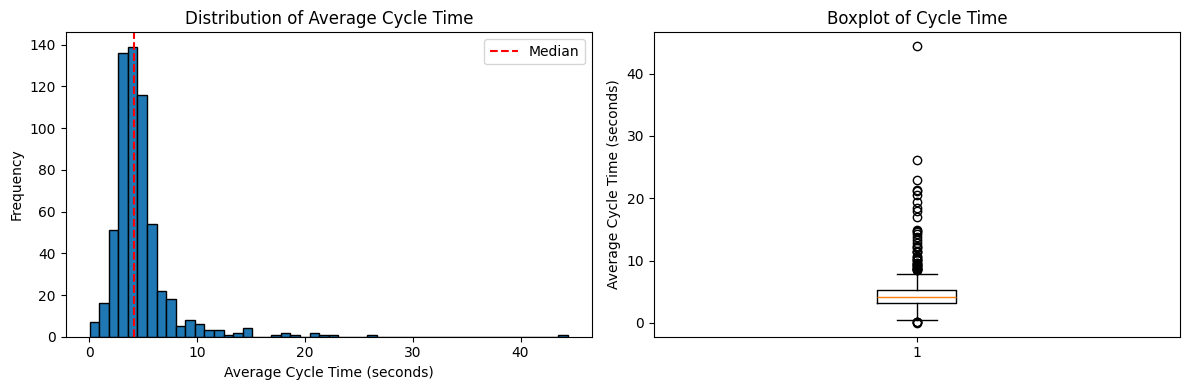


Threshold (median): 4.167 seconds

Class distribution:
speed_class
0    303
1    298
Name: count, dtype: int64

Class 0 (faster): 303 samples
Class 1 (slower): 298 samples

FEATURE SELECTION
Total features used: 467

Feature categories:
  - Joint angles and ranges
  - Angular velocities and accelerations
  - Linear velocities and accelerations
  - Static position measurements

Final dataset shape: X=(601, 467), y=(601,)

Train set: 480 samples
Test set: 121 samples

MODEL TRAINING

Training Logistic Regression...
  Train Accuracy: 0.977
  Test Accuracy: 0.843
  ROC AUC: 0.896
  CV Score: 0.829 (+/- 0.026)

Training Random Forest...
  Train Accuracy: 1.000
  Test Accuracy: 0.876
  ROC AUC: 0.933
  CV Score: 0.827 (+/- 0.019)

Training Gradient Boosting...
  Train Accuracy: 1.000
  Test Accuracy: 0.826
  ROC AUC: 0.927
  CV Score: 0.821 (+/- 0.024)

BEST MODEL: Random Forest

Classification Report:
              precision    recall  f1-score   support

  Faster (0)       0.86      0.90 

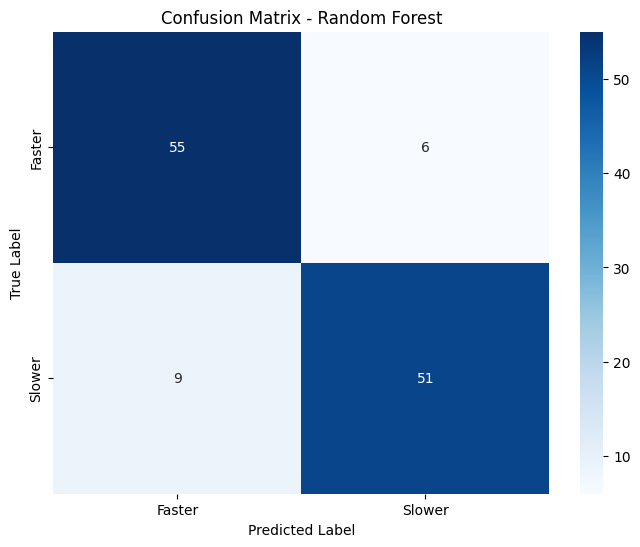

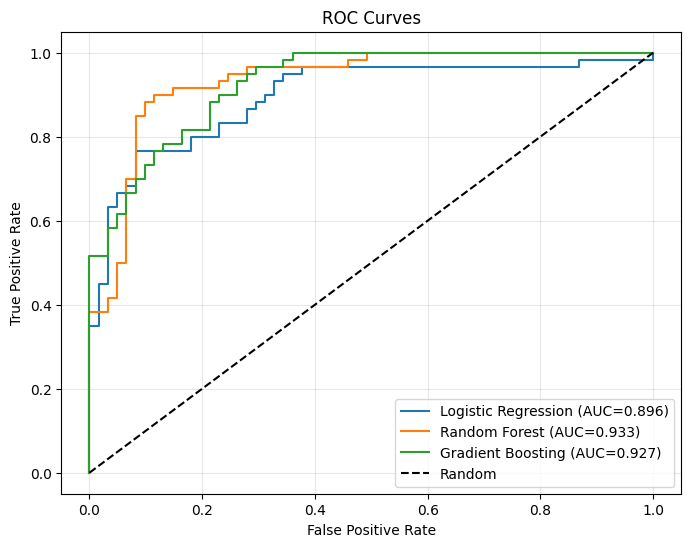


Top 20 Most Important Features:
                         feature  importance
          neck_avg_acc_sit2stand    0.033772
                pelvic_avg_speed    0.027454
          right_knee_min_ang_acc    0.023572
 left_knee_max_ang_vel_sit2stand    0.019310
      pelvic_avg_speed_stand2sit    0.018680
      pelvic_max_speed_sit2stand    0.016634
                    neck_avg_acc    0.015352
                pelvic_max_speed    0.014744
                    neck_max_acc    0.013362
     left_knee_ang_acc_sit2stand    0.011808
      pelvic_max_speed_stand2sit    0.011178
                  pelvic_avg_acc    0.010802
           left_knee_max_ang_vel    0.010704
                left_hip_ang_acc    0.010613
      left_hip_ang_acc_stand2sit    0.009636
          neck_max_acc_sit2stand    0.008972
          right_knee_max_ang_acc    0.008580
                  neck_max_speed    0.008293
right_knee_max_ang_vel_sit2stand    0.008149
    right_knee_ang_vel_stand2sit    0.007774


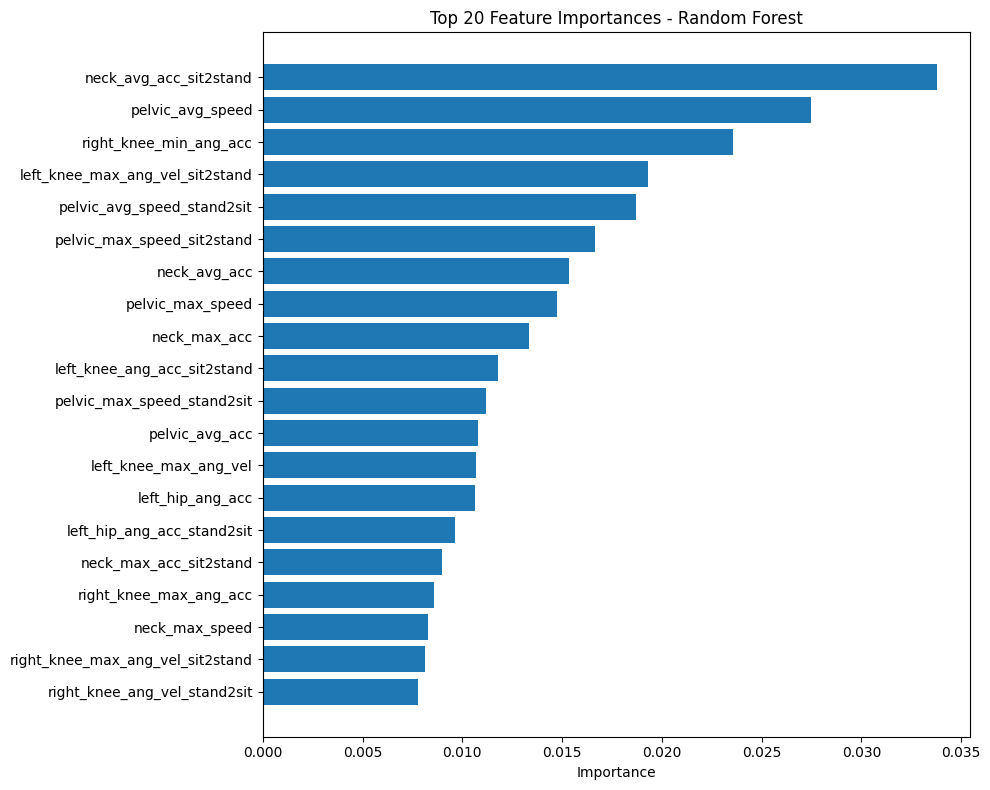


SUMMARY
Dataset: 601 subjects
Features: 467 kinematic measurements
Target: Binary classification (faster vs slower than 4.167s)

Best Model: Random Forest
  - Test Accuracy: 0.876
  - ROC AUC: 0.933

Note: This model predicts movement speed class from kinematic features.
It does NOT predict health status or make clinical assessments.

✓ Model and scaler saved to /content/
  - best_model.pkl
  - scaler.pkl


In [ ]:
# ============================================================================
# Cycle Time-Based Classification Model
# Note: This is exploratory analysis using movement speed as a proxy metric
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Load the features
df = pd.read_csv('/content/features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# ============================================================================
# Step 1: Create target variable based on average cycle time
# ============================================================================

# Calculate average cycle time (sit-to-stand + stand-to-sit)
df['avg_cycle_time'] = (df['time_sit2stand'] + df['time_stand2sit']) / 2

# Remove any rows with missing cycle time
df_clean = df.dropna(subset=['avg_cycle_time'])

print(f"\n{'='*60}")
print("CYCLE TIME STATISTICS")
print(f"{'='*60}")
print(df_clean['avg_cycle_time'].describe())

# Visualize distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_clean['avg_cycle_time'], bins=50, edgecolor='black')
plt.xlabel('Average Cycle Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Average Cycle Time')
plt.axvline(df_clean['avg_cycle_time'].median(), color='r', linestyle='--', label='Median')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df_clean['avg_cycle_time'])
plt.ylabel('Average Cycle Time (seconds)')
plt.title('Boxplot of Cycle Time')

plt.tight_layout()
plt.savefig('/content/cycle_time_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Step 2: Create binary classification labels
# Using median as threshold (balanced classes)
# ============================================================================

threshold = df_clean['avg_cycle_time'].median()

# 0 = Faster than median, 1 = Slower than median
df_clean['speed_class'] = (df_clean['avg_cycle_time'] > threshold).astype(int)

print(f"\nThreshold (median): {threshold:.3f} seconds")
print(f"\nClass distribution:")
print(df_clean['speed_class'].value_counts())
print(f"\nClass 0 (faster): {(df_clean['speed_class']==0).sum()} samples")
print(f"Class 1 (slower): {(df_clean['speed_class']==1).sum()} samples")

# ============================================================================
# Step 3: Prepare features (exclude time-related features)
# ============================================================================

# Columns to exclude from features
exclude_cols = [
    'subjectid', 'orientation', 'framerate', 'speed_class', 'avg_cycle_time',
    # Exclude all time-related features
    'time', 'time_sit2stand', 'time_stand2sit',
    'time_diff', 'time_diff_sit2stand', 'time_diff_stand2sit',
    'time_sd', 'time_sd_sit2stand', 'time_sd_stand2sit',
    'speed', 'speed_sit2stand', 'speed_stand2sit',
    'speed_sd', 'speed_sd_sit2stand', 'speed_sd_stand2sit',
    'n', 'n_sit2stand', 'n_stand2sit'
]

# Get feature columns
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

# Remove any columns with all NaN
feature_cols = [col for col in feature_cols if df_clean[col].notna().sum() > 0]

print(f"\n{'='*60}")
print("FEATURE SELECTION")
print(f"{'='*60}")
print(f"Total features used: {len(feature_cols)}")
print(f"\nFeature categories:")
print(f"  - Joint angles and ranges")
print(f"  - Angular velocities and accelerations")
print(f"  - Linear velocities and accelerations")
print(f"  - Static position measurements")

# Prepare X and y
X = df_clean[feature_cols].fillna(0)  # Fill any remaining NaN with 0
y = df_clean['speed_class']

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")

# ============================================================================
# Step 4: Train-test split and scaling
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ============================================================================
# Step 5: Train multiple models
# ============================================================================

print(f"\n{'='*60}")
print("MODEL TRAINING")
print(f"{'='*60}")

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

    results[name] = {
        'model': model,
        'train_acc': train_score,
        'test_acc': test_score,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  Train Accuracy: {train_score:.3f}")
    print(f"  Test Accuracy: {test_score:.3f}")
    print(f"  ROC AUC: {auc_score:.3f}")
    print(f"  CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# ============================================================================
# Step 6: Detailed evaluation of best model
# ============================================================================

best_model_name = max(results, key=lambda x: results[x]['test_acc'])
best_result = results[best_model_name]

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*60}")

print("\nClassification Report:")
print(classification_report(y_test, best_result['y_pred'],
                          target_names=['Faster (0)', 'Slower (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_result['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faster', 'Slower'],
            yticklabels=['Faster', 'Slower'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/content/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Step 7: Feature Importance (for tree-based models)
# ============================================================================

if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_result['model'].feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    print(feature_importance.head(20).to_string(index=False))

    # Plot top 20 features
    plt.figure(figsize=(10, 8))
    top_20 = feature_importance.head(20)
    plt.barh(range(len(top_20)), top_20['importance'])
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('/content/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# Step 8: Summary
# ============================================================================

print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"Dataset: {len(df_clean)} subjects")
print(f"Features: {len(feature_cols)} kinematic measurements")
print(f"Target: Binary classification (faster vs slower than {threshold:.3f}s)")
print(f"\nBest Model: {best_model_name}")
print(f"  - Test Accuracy: {best_result['test_acc']:.3f}")
print(f"  - ROC AUC: {best_result['auc']:.3f}")
print(f"\nNote: This model predicts movement speed class from kinematic features.")
print(f"It does NOT predict health status or make clinical assessments.")

# Save the model and scaler
import pickle

with open('/content/best_model.pkl', 'wb') as f:
    pickle.dump(best_result['model'], f)

with open('/content/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n✓ Model and scaler saved to /content/")
print("  - best_model.pkl")
print("  - scaler.pkl")

Dataset shape: (601, 488)
Threshold (median): 4.167 seconds
Class 0 (faster): 303 samples
Class 1 (slower): 298 samples

ANGLE-ONLY FEATURE SELECTION
Total features used: 257

Feature types included:
  - Joint angle ranges (min, max, mean, sd)
  - Static position measurements
  - Distance ratios

Features excluded:
  - All velocities (angular and linear)
  - All accelerations (angular and linear)

Selected features:
   1. left_knee_range_mean
   2. left_knee_sd
   3. left_knee_max
   4. left_knee_min
   5. left_knee_max_mean
   6. left_knee_min_mean
   7. left_knee_max_sd
   8. left_knee_min_sd
   9. right_knee_range_mean
  10. right_knee_sd
  11. right_knee_max
  12. right_knee_min
  13. right_knee_max_mean
  14. right_knee_min_mean
  15. right_knee_max_sd
  16. right_knee_min_sd
  17. left_hip_range_mean
  18. left_hip_sd
  19. left_hip_max
  20. left_hip_min
  21. left_hip_max_mean
  22. left_hip_min_mean
  23. left_hip_max_sd
  24. left_hip_min_sd
  25. right_hip_range_mean
  26. r

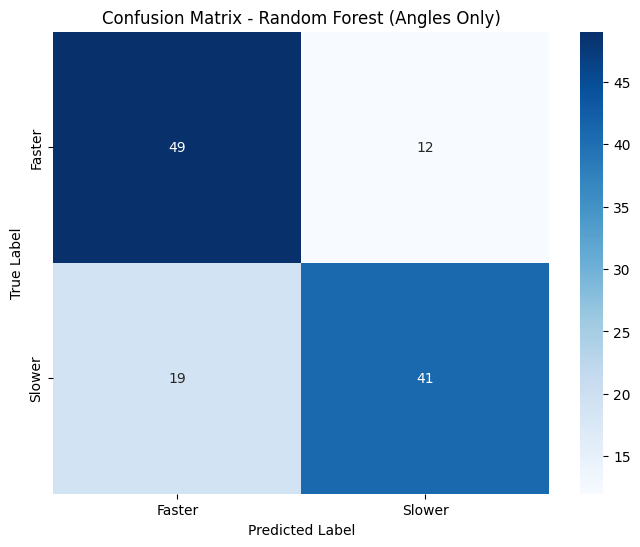

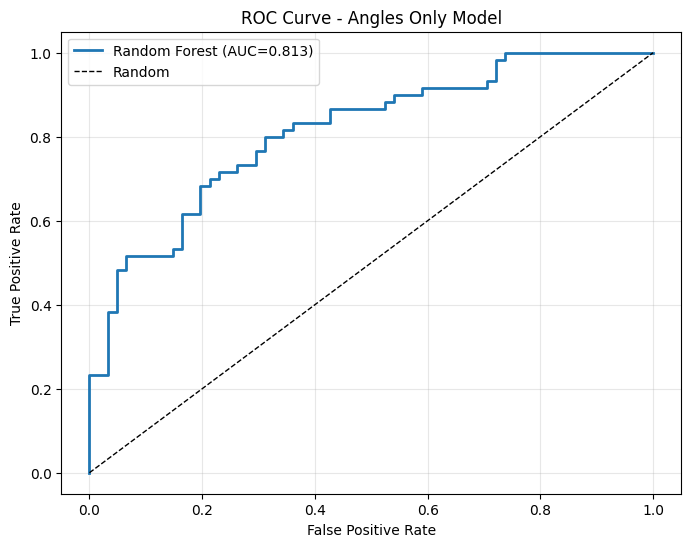


FEATURE IMPORTANCE RANKING

All features ranked by importance:
                               feature  importance
           trunk_lean_min_sd_sit2stand    0.014851
                       left_hip_max_sd    0.014142
           left_hip_max_mean_stand2sit    0.013962
              trunk_lean_max_sit2stand    0.013911
                     left_hip_max_mean    0.013789
            alignment_min_sd_sit2stand    0.012720
              right_knee_max_sit2stand    0.011139
                      alignment_min_sd    0.010954
       trunk_lean_range_mean_stand2sit    0.009712
               right_hip_max_sit2stand    0.009013
           trunk_lean_min_sd_stand2sit    0.008909
         trunk_lean_max_mean_sit2stand    0.008767
                          left_hip_max    0.008552
                left_knee_sd_sit2stand    0.007933
          alignment_max_mean_sit2stand    0.007638
            alignment_min_sd_stand2sit    0.007585
                      alignment_max_sd    0.007448
   left_shank_angl

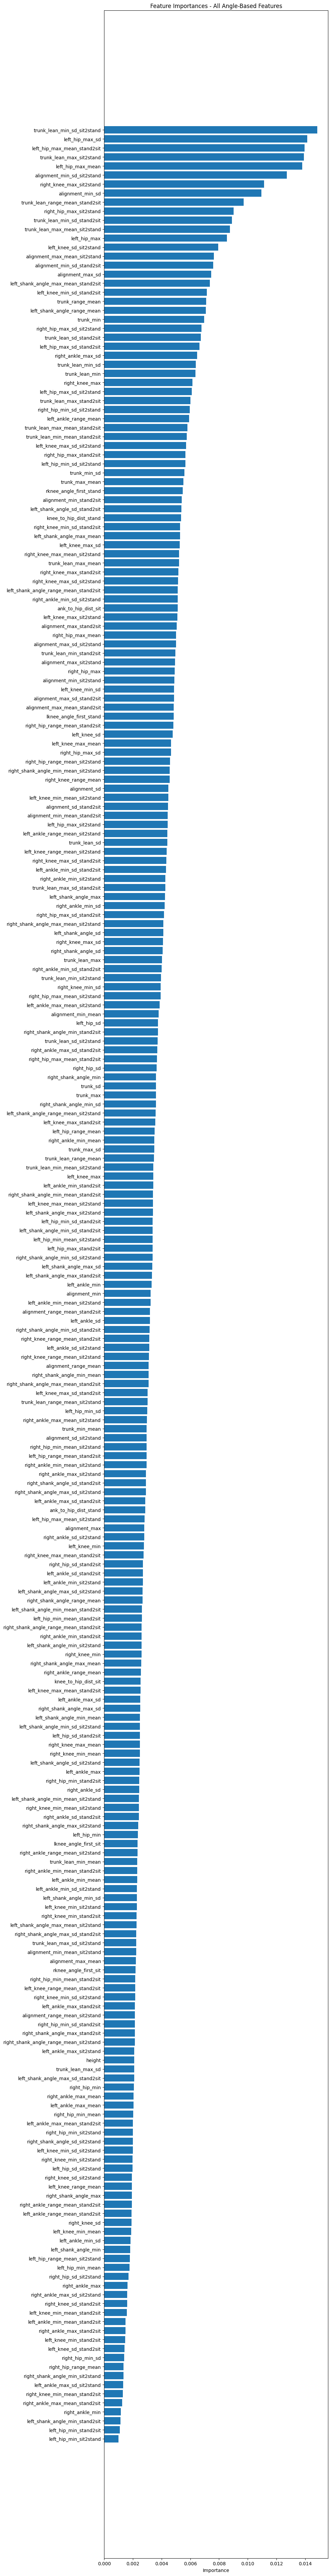


Features accounting for 90% of importance: 202/257

Top features (90% cumulative importance):
                               feature  importance
           trunk_lean_min_sd_sit2stand    0.014851
                       left_hip_max_sd    0.014142
           left_hip_max_mean_stand2sit    0.013962
              trunk_lean_max_sit2stand    0.013911
                     left_hip_max_mean    0.013789
            alignment_min_sd_sit2stand    0.012720
              right_knee_max_sit2stand    0.011139
                      alignment_min_sd    0.010954
       trunk_lean_range_mean_stand2sit    0.009712
               right_hip_max_sit2stand    0.009013
           trunk_lean_min_sd_stand2sit    0.008909
         trunk_lean_max_mean_sit2stand    0.008767
                          left_hip_max    0.008552
                left_knee_sd_sit2stand    0.007933
          alignment_max_mean_sit2stand    0.007638
            alignment_min_sd_stand2sit    0.007585
                      alignment_max_sd

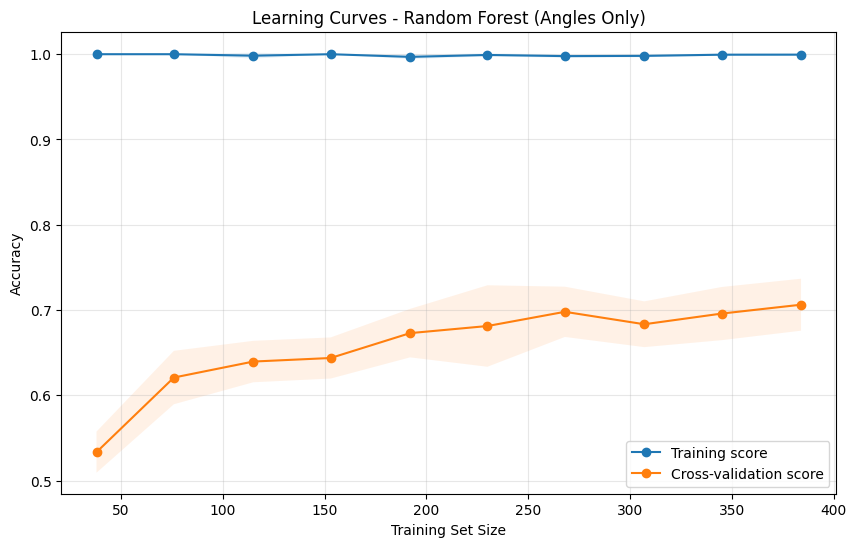


SUMMARY
Model: Random Forest (Optimized)
Features: 257 angle-based measurements only
Test Accuracy: 0.744
ROC AUC: 0.813

Model saved to:
  - /content/rf_angles_only.pkl
  - /content/scaler_angles_only.pkl
  - /content/feature_cols_angles_only.pkl


In [2]:
# ============================================================================
# Angle-Only Random Forest Model (No Velocities/Accelerations)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Load the features
df = pd.read_csv('/content/features.csv')

print(f"Dataset shape: {df.shape}")

# ============================================================================
# Step 1: Create target variable (same as before)
# ============================================================================

df['avg_cycle_time'] = (df['time_sit2stand'] + df['time_stand2sit']) / 2
df_clean = df.dropna(subset=['avg_cycle_time'])

threshold = df_clean['avg_cycle_time'].median()
df_clean['speed_class'] = (df_clean['avg_cycle_time'] > threshold).astype(int)

print(f"Threshold (median): {threshold:.3f} seconds")
print(f"Class 0 (faster): {(df_clean['speed_class']==0).sum()} samples")
print(f"Class 1 (slower): {(df_clean['speed_class']==1).sum()} samples")

# ============================================================================
# Step 2: Select ONLY angle-based features (exclude velocity/acceleration)
# ============================================================================

# Start with all columns
all_cols = df_clean.columns.tolist()

# Columns to always exclude
exclude_cols = [
    'subjectid', 'orientation', 'framerate', 'speed_class', 'avg_cycle_time',
    # Time features
    'time', 'time_sit2stand', 'time_stand2sit',
    'time_diff', 'time_diff_sit2stand', 'time_diff_stand2sit',
    'time_sd', 'time_sd_sit2stand', 'time_sd_stand2sit',
    'speed', 'speed_sit2stand', 'speed_stand2sit',
    'speed_sd', 'speed_sd_sit2stand', 'speed_sd_stand2sit',
    'n', 'n_sit2stand', 'n_stand2sit'
]

# Keywords to exclude (velocities and accelerations)
velocity_keywords = ['vel', 'speed', 'acc']

# Get candidate features
candidate_cols = [col for col in all_cols if col not in exclude_cols]

# Filter out velocity/acceleration features
feature_cols = []
for col in candidate_cols:
    # Check if any velocity/acceleration keyword is in the column name
    if not any(keyword in col.lower() for keyword in velocity_keywords):
        feature_cols.append(col)

# Remove columns with all NaN
feature_cols = [col for col in feature_cols if df_clean[col].notna().sum() > 0]

print(f"\n{'='*60}")
print("ANGLE-ONLY FEATURE SELECTION")
print(f"{'='*60}")
print(f"Total features used: {len(feature_cols)}")
print(f"\nFeature types included:")
print(f"  - Joint angle ranges (min, max, mean, sd)")
print(f"  - Static position measurements")
print(f"  - Distance ratios")
print(f"\nFeatures excluded:")
print(f"  - All velocities (angular and linear)")
print(f"  - All accelerations (angular and linear)")

print(f"\nSelected features:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Prepare X and y
X = df_clean[feature_cols].fillna(0)
y = df_clean['speed_class']

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")

# ============================================================================
# Step 3: Train-test split and scaling
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ============================================================================
# Step 4: Hyperparameter tuning with GridSearchCV
# ============================================================================

print(f"\n{'='*60}")
print("HYPERPARAMETER TUNING")
print(f"{'='*60}")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Running grid search (this may take a few minutes)...")
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation ROC AUC: {grid_search.best_score_:.3f}")

# ============================================================================
# Step 5: Train final model with best parameters
# ============================================================================

best_rf = grid_search.best_estimator_

# Predictions
y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)
y_test_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Metrics
train_acc = best_rf.score(X_train_scaled, y_train)
test_acc = best_rf.score(X_test_scaled, y_test)
auc_score = roc_auc_score(y_test, y_test_proba)

# Cross-validation on full training set
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\n{'='*60}")
print("FINAL MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"ROC AUC: {auc_score:.3f}")
print(f"CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred,
                          target_names=['Faster (0)', 'Slower (1)']))

# ============================================================================
# Step 6: Visualizations
# ============================================================================

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Faster', 'Slower'],
            yticklabels=['Faster', 'Slower'])
plt.title('Confusion Matrix - Random Forest (Angles Only)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('/content/confusion_matrix_angles_only.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC={auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Angles Only Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('/content/roc_curve_angles_only.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Step 7: Feature Importance Analysis
# ============================================================================

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n{'='*60}")
print("FEATURE IMPORTANCE RANKING")
print(f"{'='*60}")
print("\nAll features ranked by importance:")
print(feature_importance.to_string(index=False))

# Plot all features
plt.figure(figsize=(10, max(8, len(feature_cols)*0.3)))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.title('Feature Importances - All Angle-Based Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/content/feature_importance_angles_only.png', dpi=300, bbox_inches='tight')
plt.show()

# Cumulative importance
cumulative_importance = feature_importance['importance'].cumsum()
n_features_90 = (cumulative_importance < 0.9).sum() + 1

print(f"\nFeatures accounting for 90% of importance: {n_features_90}/{len(feature_cols)}")
print("\nTop features (90% cumulative importance):")
print(feature_importance.head(n_features_90).to_string(index=False))

# ============================================================================
# Step 8: Learning curves
# ============================================================================

from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train_scaled, y_train,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Cross-validation score', marker='o')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves - Random Forest (Angles Only)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('/content/learning_curves_angles_only.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# Step 9: Save model
# ============================================================================

import pickle

with open('/content/rf_angles_only.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

with open('/content/scaler_angles_only.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('/content/feature_cols_angles_only.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"Model: Random Forest (Optimized)")
print(f"Features: {len(feature_cols)} angle-based measurements only")
print(f"Test Accuracy: {test_acc:.3f}")
print(f"ROC AUC: {auc_score:.3f}")
print(f"\nModel saved to:")
print(f"  - /content/rf_angles_only.pkl")
print(f"  - /content/scaler_angles_only.pkl")
print(f"  - /content/feature_cols_angles_only.pkl")